# RTED-TDS Co-Sim

Authored by [Jinning Wang](https://scholar.google.com/citations?user=Wr7nQZAAAAAJ&hl=en&oi=ao), recently updated on 06/06/2022.

This notebook is used to implement the Co-Simulation of Real Time Economic Dispatch (RTED) and Time-Domain Simulation (TDS).
In the RTED, SFR is considered. In the TDS, AGC is implemented with an equation defined PI controller.

RTED is seperated into two DCOPF and ACOPF: 1) DCOPF with SFR is solved in gurobipy, which is packaged into the class ``rted`` in the file ``rted.py``. 2) ACOPF is solved in pandapower.

Class ``rted2`` has attributes ``mdl`` which is a gurobipy model.

Table of contents:
- Import case: import ADNES case
- Load synthetic: build load curve as a scalar
- Setup ``ssp`` and ``ssd``
- Prepare: define some functions
- Define param: define RTED loop parameters
- Loop: Co-Sim loop

List of major vars:

- ``ssa`` ANDES system
- ``ssp`` pandapower net
- ``ssd`` DCOPF instance
- ``sse`` EV aggregator

Things need to be done when switching to other cases:
- Assign generator cost data. The rows of gen_cost array should be the same with the length of ``ssp.gen``
  including those uncontrollable ones, so the DCOPF model can build correctly.
- Define generator controllability of ``ssp``, all generators are controllable by default
- Define power system data: SFR cost, ramp limit (5-min-based)
- Define generator type in ``ssd``, default as type I. For type I generator, generator limtis have impact on both generation and SFR capacity. For yype II generator, SFR capacity is determined by param ``pru_max`` and ``prd_max``

Environment requirements:
- ANDES (1.6.3+)
- pandapower (2.7.0 is tested to be function correctly)
- gurobipy
- pandas, matplotlib, scipy

## Import case

In [1]:
%run -i 'cosim_import.py'

0.post4533.dev0+gbbaaf89
2.8.0


In [2]:
ict = True
ecc = True
agc = True
caseH = 18

In [3]:
ss1 = ev_ssm(ts=caseH, N=50000, step=1, tp=40,
             lr=0.1, lp=60, seed=2022, name="EVA",
             n_pref=1, is_report=True,
             tt_mean=0.3, tt_var=0.01, tt_lb=0, tt_ub=0.6,
             ict=True, ecc=ecc, agc=agc)
ss2 = ev_ssm(ts=caseH, N=50000, step=1, tp=40,
             lr=0.1, lp=60, seed=2022, name="EVA",
             n_pref=1, is_report=True,
             tt_mean=0.3, tt_var=0.01, tt_lb=0, tt_ub=0.6,
             ict=False, ecc=ecc, agc=agc)

EVA: ts=18[H], 50000 EVs, Total Q=434.54 MWh
Online 14477, Q=362.27 MWh, SoC=0.7435
Power(MW): Pt=-39.0266, Pc=-39.0266, Pd=0.0
Ctrl: 0=7897; 1=6580; 
EVA: ts=18[H], 50000 EVs, Total Q=434.54 MWh
Online 14477, Q=362.27 MWh, SoC=0.7435
Power(MW): Pt=-39.0266, Pc=-39.0266, Pd=0.0
Ctrl: 0=7897; 1=6580; 


In [4]:
# x10 = ss1.x0.copy()
# x20 = ss2.x0.copy()

# u1, v1, us1, vs1, usp1, vsp1, Pi_cap1, error1 = ss1.r_agc(20)
# u2, v2, us2, vs2, usp2, vsp2, Pi_cap2, error2 = ss2.r_agc(20)

# x11 = ss1.x0.copy()
# x21 = ss2.x0.copy()

# dx1 = x11 - x10
# dx2 = x21 - x20

In [5]:
# f1, ax = plt.subplots(1, 1, figsize=(15, 5))
# ax.bar(x=range(60), height=dx1, label='dx1', alpha=1, color='tab:green')
# ax.bar(x=range(60), height=dx2, label='dx2', alpha=0.5, color='tab:blue')
# ax.grid()
# ax.set_xlim([0, 60])

In [6]:
ss1.run(tf=caseH+4/3600, Pi=50,
        is_updateA=False, is_rstate=True,
        is_test=False, disable=True)
ss2.run(tf=caseH+4/3600, Pi=50,
        is_updateA=False, is_rstate=True,
        is_test=False, disable=True)

(<Figure size 600x300 with 1 Axes>,
 <AxesSubplot:title={'center':'AGC response'}, xlabel='Time [s]', ylabel='Power (MW)'>)

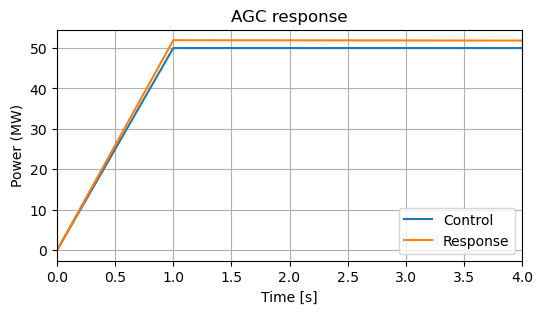

In [7]:
ss1.plot_agc()

(<Figure size 600x300 with 1 Axes>,
 <AxesSubplot:title={'center':'AGC response'}, xlabel='Time [s]', ylabel='Power (MW)'>)

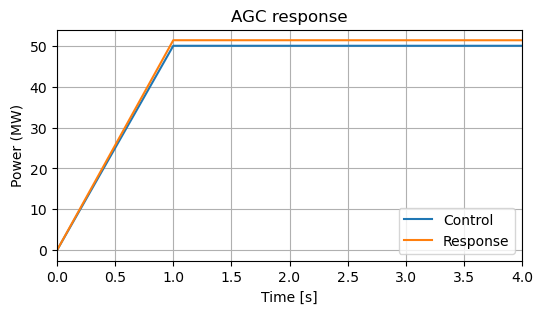

In [8]:
ss2.plot_agc()

plt.style.use('science')
%run -i 'cosim_plotev.py'